# Bandgap prediction using Element Fraction Data
This notebook uses Element Fraction data in order to predict bandgaps of certain compositions
Following the Ward 2016 paper, this notebook provides machine learning techniques trained on composition attributes 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import itertools
import pandas as pd
import matminer
import sys
sys.path.append("/Users/Ashwin/Desktop/git/matminer")
from pymatgen import Composition
from matminer.descriptors.composition_features import ElementFractionAttribute
from pymatgen import Element
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
import datetime
%matplotlib inline


In [2]:
training_file = "data/oqmd_all.csv"

# Load training data from oqmd database

In [3]:
training_set = pd.read_csv(training_file, delim_whitespace=True, na_values=['None', np.inf])
training_set.head()
training_set.shape

(347329, 7)

In [4]:
min_value = min(np.array(training_set['energy_pa'], dtype=float))
#Replace outlier values
training_set = training_set.replace(str(min_value), np.nan)
training_set.dropna(inplace=True)

In [5]:
training_set['is_groundstate'] = False
training_set.shape

(173910, 8)

# Get all groundstate values for each compound
Sort by energy_pa : for repeated compounds, only keep lowest energy state

In [6]:
%%time
for gid, group in training_set.groupby('comp'):
    if group.shape[0] > 1:
        group = group.sort_values('energy_pa', ascending=True)    
    training_set.loc[group.iloc[0].name, 'is_groundstate'] = True
    
    #training_set.iloc[group.energy_pa.idxmin(axis=1)]['is_groundstate']= True
    #print("break")
    #print(training_set.iloc[group.energy_pa.idxmin(axis=1)])
    #training_set.iloc[group.energy_pa.idxmin(axis=1)]['is_groundstate'] = True

CPU times: user 2min 13s, sys: 2.17 s, total: 2min 15s
Wall time: 2min 20s


In [7]:
original_count = len(training_set)
training_set = training_set[training_set['is_groundstate']]
removed = original_count - len(training_set)
print("Removed", removed, "/", original_count)

Removed 50279 / 173910


# Compute descriptors using MatMiner

In [8]:
def calc_attributes(training_set):
    training_set_updated = ElementFractionAttribute().featurize_all(training_set, col_id="comp")
    return training_set_updated
training_set_bg = calc_attributes(training_set)
training_set_bg.shape

(123631, 111)

In [9]:
# Actual bandgap for regression step
bandgaps = np.array(training_set_bg["bandgap"], dtype=float)
#Round to integer values for classification step
bg_range = np.zeros(np.shape(bandgaps), dtype=str)
for i in range(len(bandgaps)):
    if bandgaps[i] == 0:
        bg_range[i] = "0"
    elif bandgaps[i] > 0 and bandgaps[i] < 1.5:
        bg_range[i] = "1"
    elif bandgaps[i] >= 1.5 and bandgaps[i] < 3.0:
        bg_range[i] = "2"
    elif bandgaps[i] >= 3.0:
        bg_range[i] = "3"

In [10]:
#drop default columns
cols_to_drop = ['comp', 'energy_pa', 'volume_pa', 'magmom_pa', 'bandgap', 'delta_e', 'stability', 'is_groundstate']

# Predict Bandgaps 
### Random Forest Classifier

In [11]:
rfc = RandomForestClassifier(n_estimators=10, criterion="gini", min_samples_split=2)
rfc.fit(training_set_bg.drop(cols_to_drop, axis=1), bg_range)
rfc_prediction = rfc.predict(training_set_bg.drop(cols_to_drop, axis=1))

In [12]:
pd.crosstab(bg_range, rfc_prediction, rownames=['actual'], colnames=['predicted'])

predicted,0,1,2,3
actual,,,,
0,118316,3,3,6
1,157,2068,4,3
2,54,7,1819,3
3,32,1,4,1151


### Decision Tree Classifier

In [13]:
dtc = DecisionTreeClassifier()
dtc.fit(training_set_bg.drop(cols_to_drop, axis=1), bg_range)
dtc_prediction = dtc.predict(training_set_bg.drop(cols_to_drop, axis=1))

In [14]:
pd.crosstab(bg_range, dtc_prediction, rownames=['actual'], colnames=['predicted'])

predicted,0,1,2,3
actual,,,,
0,118328,0,0,0
1,0,2232,0,0
2,0,0,1883,0
3,0,0,0,1188


### Random Forest Regressor

In [15]:
rf_model = RandomForestRegressor(n_estimators=100, n_jobs = -1)
rf_model.fit(training_set_bg.drop(cols_to_drop, axis=1), bandgaps)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [16]:
rf_prediction = rf_model.predict(training_set_bg.drop(cols_to_drop, axis=1))

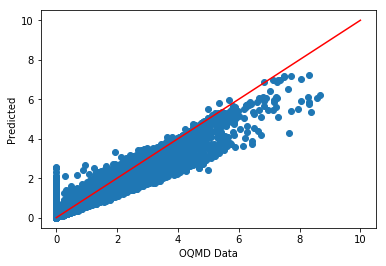

In [17]:
plt.scatter(bandgaps, rf_prediction)
plt.plot(range(11), range(11), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

### Random Forest Regressor Error

In [18]:
import time
#Find error in RandomForestRegressor
cv_start = time.time()

errors = cross_val_score(RandomForestRegressor(), training_set_bg.drop(cols_to_drop, axis=1), bandgaps, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print(mae)
cv_time = time.time()-cv_start
print("Cross-validation time: ", cv_time)


0.0884661919553
Cross-validation time:  173.00808095932007


### Decision Tree Regressor

In [19]:
dt_model = DecisionTreeRegressor()
dt_model.fit(training_set_bg.drop(cols_to_drop, axis=1), bandgaps)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [20]:
dt_prediction = dt_model.predict(training_set_bg.drop(cols_to_drop, axis=1))

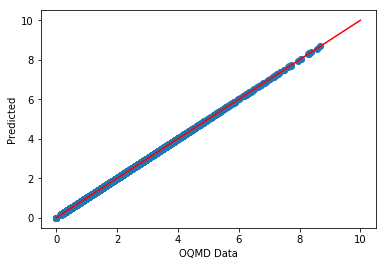

In [21]:
plt.scatter(bandgaps, dt_prediction)
plt.plot(range(11), range(11), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

### Support Vector Classification 80/20 split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(training_set_bg.drop(cols_to_drop, axis=1), bg_range, test_size=0.2, random_state=0)

In [ ]:
%%time
clf = svm.SVC(kernel='linear', C=1e3).fit(X_train, y_train)
print(clf.score(X_test, y_test))

### KFold Cross Validation

In [ ]:
%%time
clf2 = svm.SVC(kernel='linear', C=1e3)
scores = cross_val_score(clf2, training_set_bg.drop(cols_to_drop, axis=1), bg_range, cv=3)
scores

In [ ]:
print("Accuracy %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

# Predict Formation Energy

In [41]:
training_set_epa = training_set_bg
training_set_epa.head()

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability,is_groundstate,Ac,Ag,...,Tl,Tm,U,V,W,Xe,Y,Yb,Zn,Zr
69,V1,-8.940979,13.1686,0.002313,0.0,0.000000,0.000000,True,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
74,Rh1,-7.269405,13.9855,-0.014167,0.0,0.000000,0.000000,True,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,Ir1,-8.854920,14.4652,0.003235,0.0,0.000000,0.000000,True,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90,Pt1,-6.055760,15.5403,0.021855,0.0,0.000000,0.000000,True,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,Sm1Zn1,-3.317846,23.9356,0.015790,0.0,-0.327448,-0.044983,True,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0


In [42]:
# Remove Outliers
min_value = training_set_epa.min().delta_e
training_set_epa.replace((min_value), np.nan, inplace=True)
training_set_epa.dropna(inplace=True)

In [43]:
#Descretize into pos/neg formation energy

delta_e = np.array(training_set_epa['delta_e'], dtype=float)
#will hold pos/neg for each element in delta_e
energy_range = np.zeros(np.shape(delta_e), dtype=str)
for i in range(len(delta_e)):
    if delta_e[i] < 0:
        energy_range[i] = 'neg'
    else:
        energy_range[i] = 'pos'
energy_range

array(['p', 'p', 'p', ..., 'n', 'n', 'n'], 
      dtype='<U1')

In [44]:
training_set_epa.drop('bandgap', axis=1).isnull().values.any()

False

### Random Forest Classifier

In [45]:
#Random Forest Classifier

rfc = RandomForestClassifier(n_estimators=10, criterion='gini', min_samples_split=2)
rfc.fit(training_set_epa.drop(cols_to_drop, axis=1), energy_range)
rfc_prediction = rfc.predict(training_set_epa.drop(cols_to_drop, axis=1))

In [46]:
pd.crosstab(energy_range, rfc_prediction, rownames=['actual'], colnames=['predicted'])

predicted,n,p
actual,,
n,36477,209
p,306,81824


### Decision Tree Classifier

In [47]:
dtc = DecisionTreeClassifier()
dtc.fit(training_set_epa.drop(cols_to_drop, axis=1), energy_range)
dtc_prediction = dtc.predict(training_set_epa.drop(cols_to_drop, axis=1))

In [48]:
pd.crosstab(energy_range, dtc_prediction, rownames=['actual'], colnames=['predicted'])

predicted,n,p
actual,,
n,36686,0
p,0,82130


### Random Forest Regressor

In [49]:
rf_model = RandomForestRegressor(n_jobs=1)
print(np.shape(training_set_epa))
print(np.shape(delta_e))
rf_model.fit(training_set_epa.drop(cols_to_drop, axis=1), delta_e)
rf_prediction = rf_model.predict(training_set_epa.drop(cols_to_drop, axis=1))

(118816, 111)
(118816,)


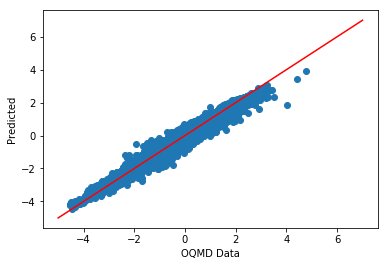

In [50]:
plt.scatter(delta_e, rf_prediction)
plt.plot(range(-5, 8), range(-5, 8), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

### Random Forest Regressor Error

In [51]:
cv_start = time.time()
errors = cross_val_score(RandomForestRegressor(), training_set_epa.drop(cols_to_drop, axis=1),delta_e, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print(mae)
cv_time = time.time() - cv_start
print("Cross-validation time: ", cv_time)

0.262980052831
Cross-validation time:  238.86547780036926


### Decision Tree Regressor

In [52]:
dt_model = DecisionTreeRegressor()
dt_model.fit(training_set_epa.drop(cols_to_drop, axis=1), delta_e)
dt_prediction = dt_model.predict(training_set_epa.drop(cols_to_drop, axis=1))

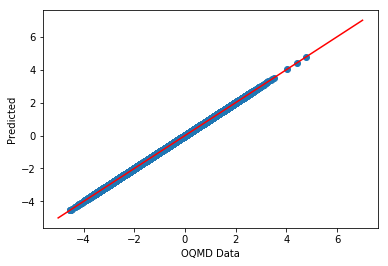

In [53]:
plt.scatter(delta_e, dt_prediction)
plt.plot(range(-5, 8), range(-5, 8), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

### Support Vector Classification 80/20 split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(training_set_epa.drop(cols_to_drop, axis=1), energy_range, test_size=0.2, random_state = 0)

In [ ]:
%%time
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

### KFold Cross Validation

In [ ]:
%%time
clf2 = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf2, training_set_epa.drop(cols_to_drop, axis=1), energy_range, cv=5)
scores

In [ ]:
print("Accuracy %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

# Predicting Volume per Atom

In [54]:
#Remove outliers
max_value = max(np.array(training_set_bg['volume_pa'], dtype=float))
training_set_vol = training_set_bg.replace(str(max_value), np.nan)

In [55]:
training_set_vol.dropna(inplace=True)

In [56]:
# Actual volume values for regression
volume_pa = np.array(training_set_vol['volume_pa'], dtype=float)
# Classified volume values for classifiers
vol_range = np.zeros(np.shape(volume_pa), dtype=str)
for i in range(len(volume_pa)):
    if volume_pa[i] < 20:
        vol_range[i] = "0"
    elif volume_pa[i] >= 20 and volume_pa[i] < 40:
        vol_range[i] = '1'
    elif volume_pa[i] >= 40 and volume_pa[i] < 60:
        vol_range[i] = '2'
    elif volume_pa[i] >= 60:
        vol_range[i] = '3'

### Random Forest Classifier

In [57]:
rfc = RandomForestClassifier(n_estimators=10, criterion='gini', min_samples_split=2, n_jobs=-1)
rfc.fit(training_set_vol.drop(cols_to_drop, axis=1), vol_range)
rfc_prediction = rfc.predict(training_set_vol.drop(cols_to_drop, axis=1))


In [58]:
pd.crosstab(vol_range, rfc_prediction, rownames=['actual'], colnames=['predicted'])

predicted,0,1,2,3
actual,,,,
0,51618,149,0,0
1,448,62862,12,0
2,0,145,3381,1
3,0,1,10,189


### Decision Tree Classifier

In [59]:
dtc = DecisionTreeClassifier()
dtc.fit(training_set_vol.drop(cols_to_drop, axis=1), vol_range)
dtc_prediction = dtc.predict(training_set_vol.drop(cols_to_drop, axis=1))

In [60]:
pd.crosstab(vol_range, dtc_prediction, rownames=['actual'], colnames=['predicted'])

predicted,0,1,2,3
actual,,,,
0,51767,0,0,0
1,0,63322,0,0
2,0,0,3527,0
3,0,0,0,200


### Random Forest Regressor

In [61]:
rf_model = RandomForestRegressor()
rf_model.fit(training_set_vol.drop(cols_to_drop, axis=1), volume_pa)
rf_prediction = rf_model.predict(training_set_vol.drop(cols_to_drop, axis=1))

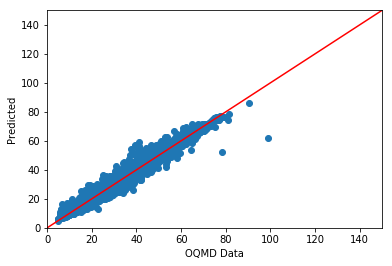

In [62]:
plt.scatter(volume_pa, rf_prediction)
plt.plot(range(0, 151), range(0, 151), 'r')
plt.axis([0, 150, 0, 150])
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

### Random Forest Regressor Error

In [63]:
cv_start = time.time()
errors = cross_val_score(RandomForestRegressor(), training_set_vol.drop(cols_to_drop, axis=1), volume_pa, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print(mae)
cv_time = time.time() - cv_start
print("Cross-validation time: ", cv_time)

2.23294104382
Cross-validation time:  234.1656358242035


### Decision Tree Regressor

In [65]:
dtr = DecisionTreeRegressor()
dtr.fit(training_set_vol.drop(cols_to_drop, axis=1), volume_pa)
dtr_prediction = dtr.predict(training_set_vol.drop(cols_to_drop, axis=1))

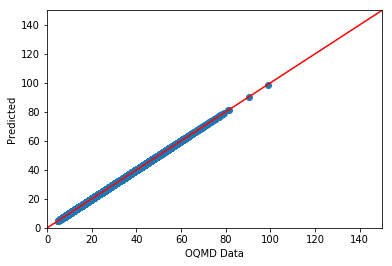

In [66]:
plt.scatter(volume_pa, dtr_prediction)
plt.plot(range(0, 151), range(0, 151), 'r')
plt.axis([0, 150, 0, 150])
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

### Support Vector Classification 80/20 split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(training_set_vol.drop(cols_to_drop, axis=1), vol_range, test_size=0.2, random_state=0)

In [ ]:
%%time
clf = svm.SVC(kernel="linear", C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
%%time
clf2 = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf2, training_set_vol.drop(cols_to_drop, axis=1), vol_range, cv=5)

In [ ]:
print("Accuracy %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))